# YOLO DS-IE method analysis and final errors for DS-II
- Notebook of predictions, labelling and training is performed in the other one

In [ ]:
NOTEBOOK_CONFIG = {
    "label_mode": True,
    "train_mode": True,
    "IMG_LENGTH": 180,
    "IMG_WIDTH": 72,
    "IMG_XDIM": 72,
    "IMG_YDIM": 180,
    "image_ranges": [(0, 72), (0, 180)],
    "image_size": [72, 180],
    "labels_type": "Labelsv0_T80kenji_detect",
    "task": "detect",
    "model_name": "YOLOv0_E12_detect",
}

In [2]:
# Folders
# Location of images
images_folder = f"docs/Data/Images_T80kenji/"
# Locations of yolo's datasets
yolo_folder = f"docs/Models/{NOTEBOOK_CONFIG['yolo_type']}/datasets/"
# Location of labels
labels_folder = f"docs/Data/{NOTEBOOK_CONFIG['labels_type']}/"
# Location of trained models
model_folder = f"docs/Models/{NOTEBOOK_CONFIG['yolo_type']}/"

In [3]:
# Path for sample image
n_image = 109
image_path = f"docs/Data/Images_T80kenji/gaussian_{n_image}.png"
label_path = f"docs/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

In [4]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
import h5py
import os
import pandas as pd
import numpy as np

from datetime import datetime
import scipy.io

from matplotlib import pyplot as plt
from adjustText import adjust_text

In [6]:
from ultralytics import YOLO
import cv2
from PIL import Image

# Load modules

In [15]:
# Training runs (best)
bst_run = {
    "YOLOv0_detect": "2023-07-26_18-50-24",
    "YOLOv0_E2_detect": "2023-08-21_09-27-11",
    "YOLOv0_E3_detect": "2023-08-21_10-25-30",
    "YOLOv0_E4_detect": "2023-08-21_14-37-58",
    "YOLOv0_E12_detect": "2023-08-21_13-57-46",
    "YOLOv0_T80kenji_detect": "2023-09-04_11-19-43",
}

In [ ]:
# Load custom model
base_path = "docs/Models"
model_path = (f"{NOTEBOOK_CONFIG['model_name']}/runs/
              {bst_run[NOTEBOOK_CONFIG['model_name']]}/
              {NOTEBOOK_CONFIG['task']}")

model = YOLO(f"{base_path}/{model_path}/train/weights/best.pt")

In [ ]:
import sys

sys.path.append("..")

In [ ]:
from helpers.gaussian_generator import generate_grid
from helpers.auxiliary_functions import parameters_extract, checkpoint_error
from helpers.aux_plotter import (
    plot_boxes,
    plot_boxes_gmm,
    gaussians_labelled,
    plot_grayscale,
    plot_box_labels,
)
from pipelines.pipelines import (
    ppl_fit_gaussians,
    ppl_error_estimation,
    ppl_yolo_predict_gaussians,
    ppl_yolo_px_predict_gaussians,
    ppl_ensemble_predict_gaussians,
)
from helpers.error_estimation import compute_error_per_gaussian

# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [17]:
filename = "docs/Data/T80_kenji.mat"
mat = {}
with h5py.File(filename, "r") as f:
    # Print all keys in the file
    print(list(f.keys()))
    for i_key in f.keys():
        mat.update({i_key: f[i_key][:]})

['T2fit', 'val_fit']


In [18]:
# Renaming as the previous data
mat["F_data"] = mat["T2fit"]
mat["Fit_flux"] = mat["val_fit"]
del mat["T2fit"]
del mat["val_fit"]

In [19]:
# Transposing to match the organization of the previous database
mat["F_data"] = mat["F_data"].T
mat["Fit_flux"] = mat["Fit_flux"].T

In [20]:
# Generate GRID
width = mat["F_data"].shape[1]
length = mat["F_data"].shape[0]
x, y = generate_grid(
    (0, width), (0, length), mat["F_data"].shape[1], mat["F_data"].shape[0]
)

In [21]:
print(mat["F_data"].shape)
print(x.shape)
print(y.shape)

(180, 72, 400)
(180, 72)
(180, 72)


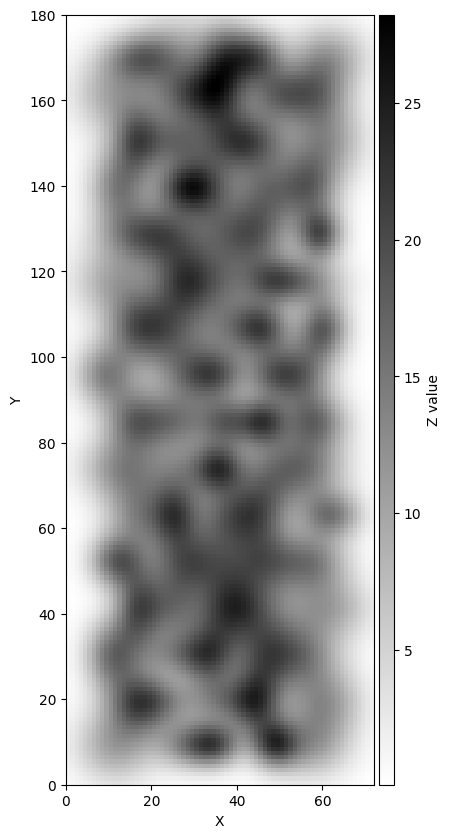

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_grayscale(x, y, mat["F_data"][:, :, 0], ax=ax)

# [ESTIMATION PART I and II]
- Images: 400
- predict_T80kenji

## [ESTIMATION] Pipeline ppl_Yolo DS-IE

In [42]:
# Make the prediction
img = cv2.imread(image_path)
results = model.predict(img)

# class 0 boxes
tensor_boxes = results[0].boxes.xyxy

# Centers
means_yolo = [
    (float(x), float(y))
    for x, y in zip(
        results[0].boxes.xywhn[:, 0] * NOTEBOOK_CONFIG["image_size"][0],
        results[0].boxes.xywhn[:, 1] * NOTEBOOK_CONFIG["image_size"][1],
    )
]


0: 640x256 91 gaussians, 569.0ms
Speed: 2.0ms preprocess, 569.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Estimate Gaussian - Final prediction
image = [x, y, mat["F_data"][:, :, n_image]]
(means, covariances, angles, amplitudes) = ppl_fit_gaussians(
    image,
    means_init="laplace",
    peak_method="laplace",
    em_iterations=1000,
    covariance_gaussians_type="diag",
    n_gaussians=None,
    image_ranges=NOTEBOOK_CONFIG["image_ranges"],
    image_size=NOTEBOOK_CONFIG["image_size"],
    fig_size=(10, 8),
    plot=True,
    plot_points=True,
)

In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 4, figsize=(15, 20))

# Display the image and plot predicted centers GMM
axs[2].imshow(im)
plot_boxes_gmm(
    means=means, covariances=covariances, ax=axs[2], beta=3, edge_color="#0343DF"
)
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(means[:, 0] * 1000, means[:, 1] * 1000, s=1)
# axs[3].axis('off')
axs[2].set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
axs[2].set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])


# Display the image and plot predicted centers
axs[3].imshow(im)
plot_boxes(tensor_boxes, axs[3], edge_color="g")
axs[3].set_ylim(axs[2].get_ylim()[::-1])
axs[3].scatter(np.array(means_yolo)[:, 0], np.array(means_yolo)[:, 1], s=1)
# axs[2].axis('off')
axs[3].set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
axs[3].set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])

# axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(
    image_path,
    label_path,
    axs[1],
    task=NOTEBOOK_CONFIG["task"],
    colorbar=False,
    plot_centers=True,
)
# axs[1].axis('off')
axs[1].set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])
axs[1].set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])
# axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar=False, ax=axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])
axs[0].set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])


for ax in axs:
    ax.xaxis.label.set_text("")
    ax.yaxis.label.set_text("")

    ax.set_xticks([])
    ax.set_yticks([])
    # Change the color of the axis spines (borders)
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")
        spine.set_linewidth(1)

plt.subplots_adjust(wspace=0.08)
plt.show()

### Error evaluation

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[208, 304, 262, 288, 77, 230, 45, 115, 172, 188, 93, 323, 371, 8, 285, 200, 383, 365, 297, 31, 28, 193, 322, 144, 286, 191, 155, 291, 109, 194, 97, 209, 310, 301, 70, 324, 4, 357, 57, 242]


In [ ]:
# Iterate all images - GMM method
results = {
    "Image": [],
    "Number identified - YOLO": [],
    "Number identifiable - YOLO": [],
    "Percentage - YOLO": [],
    "RMSE_cx - YOLO": [],
    "RMSE_cy - YOLO": [],
    "RMSE_c - YOLO": [],
    "RMSE_sigmax - YOLO": [],
    "RMSE_sigmay - YOLO": [],
    "RMSE_sigma - YOLO": [],
    "MaxE_sigmax - YOLO": [],
    "MaxE_sigmay - YOLO": [],
    "MaxE_sigma - YOLO": [],
    "RMSE_amplitude - YOLO": [],
    "RMSEPixel - YOLO": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        estimation_method="YOLO",
        image_path="docs/Data/Images_T80kenji/",
        yolo_model=model,
        covariance_gaussians_types="diag",
        return_percentage=True,
        image_ranges=NOTEBOOK_CONFIG["image_ranges"],
        image_size=NOTEBOOK_CONFIG["image_size"],
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]


0: 640x256 88 gaussians, 373.1ms
Speed: 1.3ms preprocess, 373.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     9.8104           0]
  [          0      5.8108]]]
covariances true [[[     5.3991           0]
  [          0      5.3336]]]



0: 640x256 92 gaussians, 536.7ms
Speed: 1.7ms preprocess, 536.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[      8.157           0]
  [          0      5.7845]]]
covariances true [[[     5.3992           0]
  [          0      3.9359]]]



0: 640x256 78 gaussians, 1192.6ms
Speed: 1.1ms preprocess, 1192.6ms inference, 14.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.5336           0]
  [          0      7.0598]]]
covariances true [[[     5.8366           0]
  [          0      5.4095]]]



0: 640x256 72 gaussians, 411.6ms
Speed: 1.2ms preprocess, 411.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.7912           0]
  [          0      5.4697]]]
covariances true [[[     5.3771           0]
  [          0       3.654]]]



0: 640x256 87 gaussians, 343.4ms
Speed: 1.7ms preprocess, 343.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.2322           0]
  [          0      5.7359]]]
covariances true [[[     5.5201           0]
  [          0      3.8042]]]



0: 640x256 91 gaussians, 273.2ms
Speed: 1.3ms preprocess, 273.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.1826           0]
  [          0      5.7682]]]
covariances true [[[      5.442           0]
  [          0      4.5346]]]



0: 640x256 79 gaussians, 183.4ms
Speed: 5.6ms preprocess, 183.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.7738           0]
  [          0      5.2778]]]
covariances true [[[     5.5298           0]
  [          0      3.6782]]]



0: 640x256 90 gaussians, 176.5ms
Speed: 2.5ms preprocess, 176.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.3068           0]
  [          0      5.6921]]]
covariances true [[[      5.109           0]
  [          0      3.9206]]]



0: 640x256 91 gaussians, 179.9ms
Speed: 1.2ms preprocess, 179.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     6.7295           0]
  [          0      6.2175]]]
covariances true [[[     4.6205           0]
  [          0      4.1786]]]



0: 640x256 88 gaussians, 178.5ms
Speed: 1.6ms preprocess, 178.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[      8.068           0]
  [          0      6.0308]]]
covariances true [[[     5.2537           0]
  [          0      4.1029]]]



0: 640x256 87 gaussians, 181.3ms
Speed: 7.6ms preprocess, 181.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     7.2979           0]
  [          0      6.1802]]]
covariances true [[[     5.1254           0]
  [          0      4.3112]]]


0: 640x256 91 gaussians, 186.1ms
Speed: 1.1ms preprocess, 186.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     6.4053           0]
  [          0      5.3382]]]
covariances true [[[     4.2379           0]
  [          0      3.6142]]]



0: 640x256 88 gaussians, 173.8ms
Speed: 2.0ms preprocess, 173.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.7239           0]
  [          0      5.2335]]]
covariances true [[[     5.4315           0]
  [          0      3.6159]]]



0: 640x256 83 gaussians, 193.0ms
Speed: 1.5ms preprocess, 193.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     10.221           0]
  [          0      6.2099]]]
covariances true [[[     6.2112           0]
  [          0      4.1014]]]



0: 640x256 87 gaussians, 179.7ms
Speed: 1.9ms preprocess, 179.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.1263           0]
  [          0      6.1469]]]
covariances true [[[     5.7158           0]
  [          0       4.362]]]



0: 640x256 84 gaussians, 171.7ms
Speed: 1.6ms preprocess, 171.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     9.7909           0]
  [          0      6.1112]]]
covariances true [[[     6.0482           0]
  [          0      4.2614]]]



0: 640x256 89 gaussians, 179.7ms
Speed: 2.1ms preprocess, 179.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.1559           0]
  [          0      5.9759]]]
covariances true [[[     5.7356           0]
  [          0      3.8975]]]



0: 640x256 91 gaussians, 184.5ms
Speed: 1.4ms preprocess, 184.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[      8.643           0]
  [          0      6.1916]]]
covariances true [[[     4.7311           0]
  [          0      4.1403]]]



0: 640x256 93 gaussians, 182.9ms
Speed: 1.2ms preprocess, 182.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     11.189           0]
  [          0      5.3595]]]
covariances true [[[     6.3647           0]
  [          0      4.6011]]]



0: 640x256 107 gaussians, 177.0ms
Speed: 4.1ms preprocess, 177.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.1706           0]
  [          0      6.3047]]]
covariances true [[[     5.5911           0]
  [          0      4.5893]]]



0: 640x256 88 gaussians, 182.8ms
Speed: 1.7ms preprocess, 182.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     6.9572           0]
  [          0      6.1164]]]
covariances true [[[     4.9467           0]
  [          0      4.3504]]]



0: 640x256 87 gaussians, 205.7ms
Speed: 3.5ms preprocess, 205.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.6858           0]
  [          0       5.316]]]
covariances true [[[     5.2259           0]
  [          0      3.6808]]]



0: 640x256 98 gaussians, 246.2ms
Speed: 1.1ms preprocess, 246.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     10.154           0]
  [          0      6.1785]]]
covariances true [[[     5.0186           0]
  [          0      3.8209]]]



0: 640x256 85 gaussians, 255.1ms
Speed: 3.1ms preprocess, 255.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.5492           0]
  [          0      5.7806]]]
covariances true [[[     5.5562           0]
  [          0      4.1562]]]



0: 640x256 86 gaussians, 237.7ms
Speed: 1.2ms preprocess, 237.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.4809           0]
  [          0      5.3339]]]
covariances true [[[     5.2638           0]
  [          0      3.6291]]]



0: 640x256 85 gaussians, 247.5ms
Speed: 1.3ms preprocess, 247.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.4258           0]
  [          0      5.8276]]]
covariances true [[[     5.2157           0]
  [          0      4.2721]]]



0: 640x256 92 gaussians, 171.7ms
Speed: 1.0ms preprocess, 171.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     9.9835           0]
  [          0      6.4455]]]
covariances true [[[     5.6168           0]
  [          0      5.6125]]]



0: 640x256 76 gaussians, 174.7ms
Speed: 0.9ms preprocess, 174.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     6.2705           0]
  [          0      5.4942]]]
covariances true [[[     4.2782           0]
  [          0      3.6208]]]



0: 640x256 91 gaussians, 174.0ms
Speed: 1.2ms preprocess, 174.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.8811           0]
  [          0      6.7322]]]
covariances true [[[     4.9199           0]
  [          0       4.536]]]



0: 640x256 78 gaussians, 169.2ms
Speed: 1.2ms preprocess, 169.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.7891           0]
  [          0      5.4017]]]
covariances true [[[      5.504           0]
  [          0      3.7813]]]



0: 640x256 80 gaussians, 182.7ms
Speed: 1.6ms preprocess, 182.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     9.9819           0]
  [          0      5.5732]]]
covariances true [[[     6.5822           0]
  [          0      3.7686]]]



0: 640x256 102 gaussians, 182.8ms
Speed: 1.8ms preprocess, 182.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     9.6116           0]
  [          0      5.7899]]]
covariances true [[[     5.6826           0]
  [          0      5.3656]]]



0: 640x256 84 gaussians, 188.1ms
Speed: 1.5ms preprocess, 188.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     6.7707           0]
  [          0      5.6576]]]
covariances true [[[     4.7404           0]
  [          0      3.9342]]]



0: 640x256 85 gaussians, 177.1ms
Speed: 1.6ms preprocess, 177.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.9386           0]
  [          0      5.9892]]]
covariances true [[[     5.2065           0]
  [          0      4.4869]]]



0: 640x256 87 gaussians, 180.3ms
Speed: 1.5ms preprocess, 180.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[      7.447           0]
  [          0      5.5283]]]
covariances true [[[     5.1142           0]
  [          0      3.9174]]]



0: 640x256 81 gaussians, 179.5ms
Speed: 1.1ms preprocess, 179.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.1671           0]
  [          0      5.5819]]]
covariances true [[[     4.7364           0]
  [          0      3.7523]]]



0: 640x256 85 gaussians, 177.5ms
Speed: 1.0ms preprocess, 177.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.2515           0]
  [          0      5.7272]]]
covariances true [[[     5.3038           0]
  [          0      3.8928]]]



0: 640x256 88 gaussians, 184.7ms
Speed: 2.0ms preprocess, 184.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     6.6107           0]
  [          0      5.4424]]]
covariances true [[[     4.6746           0]
  [          0      3.7125]]]



0: 640x256 97 gaussians, 173.0ms
Speed: 1.5ms preprocess, 173.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     9.1738           0]
  [          0      5.3867]]]
covariances true [[[     6.6235           0]
  [          0      3.6998]]]



0: 640x256 87 gaussians, 168.1ms
Speed: 1.2ms preprocess, 168.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.6178           0]
  [          0      5.8301]]]
covariances true [[[     4.9941           0]
  [          0      5.5869]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,203.22,112.45,383.00
Number identified - YOLO,87.45,6.66,107.00
Number identifiable - YOLO,80.00,0.00,80.00
Percentage - YOLO,109.31,8.33,133.75
RMSE_cx - YOLO,8.39,1.27,11.49
RMSE_cy - YOLO,6.20,2.57,15.89
RMSE_c - YOLO,10.58,2.24,18.15
RMSE_sigmax - YOLO,52.83,3.40,62.09
RMSE_sigmay - YOLO,22.63,2.09,27.62
RMSE_sigma - YOLO,57.53,3.10,67.50


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values("Image")

,Image,Number identified - YOLO,Number identifiable - YOLO,Percentage - YOLO,RMSE_cx - YOLO,RMSE_cy - YOLO,RMSE_c - YOLO,RMSE_sigmax - YOLO,RMSE_sigmay - YOLO,RMSE_sigma - YOLO,MaxE_sigmax - YOLO,MaxE_sigmay - YOLO,MaxE_sigma - YOLO,RMSE_amplitude - YOLO,RMSEPixel - YOLO
36,4,85,80,106.25,7.80,5.29,9.43,47.26,24.06,53.03,105.85,68.65,126.16,56.28,11.11
13,8,83,80,103.75,8.46,5.50,10.09,52.60,22.30,57.13,141.85,58.43,153.41,59.39,12.24
20,28,88,80,110.00,7.40,4.47,8.64,50.52,21.08,54.74,138.46,74.66,157.31,57.74,13.32
19,31,107,80,133.75,5.31,3.97,6.62,48.27,25.02,54.37,125.50,78.75,148.16,57.58,17.78
6,45,79,80,98.75,8.73,6.91,11.13,51.57,21.00,55.68,155.61,58.23,166.15,63.73,9.82
38,57,97,80,121.25,7.52,4.50,8.76,54.12,20.65,57.93,136.72,58.75,148.81,61.20,19.50
34,70,87,80,108.75,8.75,6.56,10.94,52.24,27.62,59.09,188.63,73.91,202.59,65.36,14.69
4,77,87,80,108.75,7.34,6.05,9.52,54.18,22.19,58.54,125.15,77.32,147.10,60.05,13.64
10,93,87,80,108.75,9.06,7.61,11.83,52.14,23.62,57.24,126.80,76.55,148.12,60.33,13.75
30,97,80,80,100.00,8.77,15.89,18.15,50.21,23.67,55.51,139.63,90.56,166.43,59.84,12.86


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"docs/Data/Images_T80kenji/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
    name="T80kenjiYOLO_modelDS_IE",
)